# Image Segmenation Using Pytorch
In this project I finetune a CNN model for basic object detection. It also includes special techniques to deal with pre processing and data augmentation of an object detection dataset that consists of bounding boxes in the form of pixel coordinates that is meant to be overlayed on top of images containing objects.
<br>
The input for the model is the image containing human or multiple humans. The output of the model is a binary mask image that tries to segment out the human and other stuff in the image.
<br>
The project flows in sequential order and the exectution of each cell gives an idea of the basic techniques and workflow of a typical machine learning application project.

In [ ]:
# binary cross entropy loss used for binary classification

In [ ]:
! pip install segmentation-models-pytorch
# package of common models through huggingface munch safetensors ...

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git
# albumentations for data augmentation, human segmentation dataset from vikram shenoy

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# Image Segmentation Configurations
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'
DEVICE =  'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 25
BATCH_SIZE = 16
LR = 0.003
IMG_SIZE = 320
ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[5]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

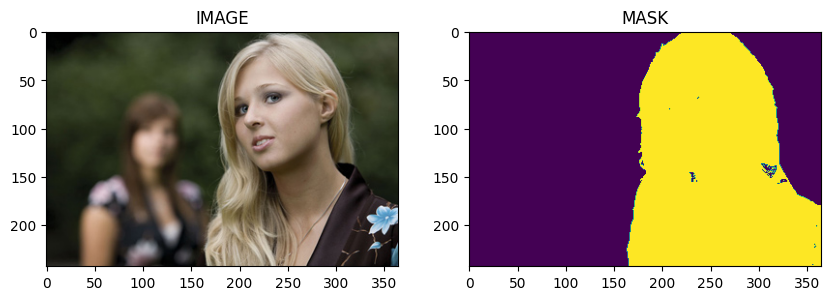

In [ ]:
# visualizing

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
ax1.set_title('IMAGE')
ax1.imshow(image)
ax2.set_title('MASK')
ax2.imshow(mask)

In [ ]:
# creating train and validation sets
train_df, valid_df = train_test_split(df, test_size= 0.2, random_state = 42)

In [ ]:
# creating custom dataset
# consideraton: mask should also augment in the same way as the image augmentation

import albumentations as A
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p = 0.5),
  ],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
  ],is_check_shapes=False)


In [ ]:
# getting image and mask pair according to the given idx

from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w, c) adding extra channel dimension
    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    # (h, w, c) -> (c, h, w)

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask)/ 255.0)

    return image, mask


In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Training Examples: {len(trainset)}")
print(f"Validation Examples: {len(validset)}")

Training Examples: 232
Validation Examples: 58


In [ ]:
# plotting helper function

def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

def overlay_image(image, mask):

  f, ax1 = plt.subplots(1,1,figsize = (5,5))
  ax1.set_title('IMAGE SEGMENTATION')
  image = image.permute(1,2,0).squeeze()
  mask = mask.permute(1,2,0).squeeze()

  image_height = image.size()[0]
  image_width = image.size()[1]

  for x_loc in range(image_width):
    for y_loc in range(image_height):
      if mask[x_loc][y_loc] != 0:
        image[x_loc][y_loc][0] =  200

  ax1.imshow(image, cmap = 'gray')


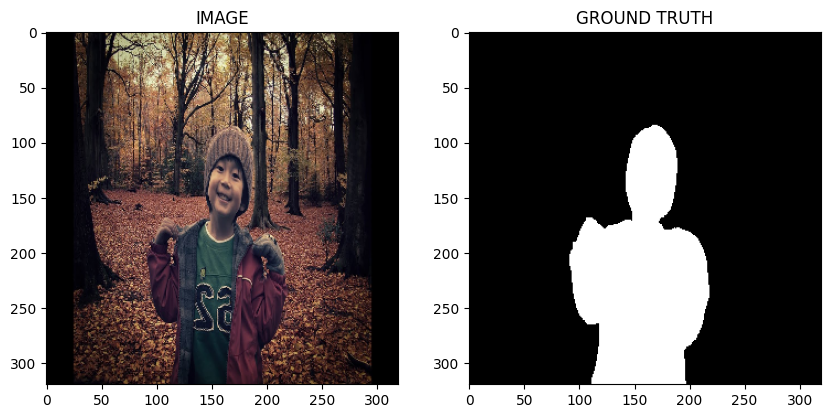

In [ ]:
# sanity check for SegmentationDataset class
idx = 21

image, mask = trainset[idx]
show_image(image, mask)

In [ ]:
# Defining the type of DataLoader to crate batches
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE, shuffle = True)

print(f'Train Batches: {len(trainloader)}')
print(f'Valid Batches: {len(validloader)}')

Train Batches: 15
Valid Batches: 4


In [ ]:
for image, mask in trainloader:
  break

print(f"Batch image shape: {image.shape}")
print(f"Batch mask shape: {mask.shape}")


Batch image shape: torch.Size([16, 3, 320, 320])
Batch mask shape: torch.Size([16, 1, 320, 320])


In [ ]:
from torch.nn.modules.conv import LazyConvTranspose2d
from torch.nn.modules import BCEWithLogitsLoss
# creating the segmentation model
# segmentation models are encoder based
# using efficientnet as the encoder and unett as the segmentation model
# TODO: clear up confusion regarding the model architecture

from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHTS,
        in_channels=3,
        classes= 1,
        activation= None # raw output without any sigmoid or softmax activations
      )

  def forward(self, images, masks = None):
    logits = self.arc(images)
    if masks != None:
        loss1 = DiceLoss(mode='binary')(logits, masks)
        loss2 = nn.BCEWithLogitsLoss()(logits, masks)
        return logits, loss1 + loss2
    return logits



In [ ]:
model = SegmentationModel()
model.to(DEVICE)

In [ ]:
# Training and Evaluation

def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward() # gradients
    optimizer.step() # weight update

    total_loss = loss.item()
  return total_loss/ len(data_loader)

def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss = loss.item()
  return total_loss/ len(data_loader)

In [ ]:
# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
best_validation_loss = np.Inf

for epoch in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)
  if valid_loss < best_validation_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Best model was updated...")
    best_validation_loss = valid_loss

  print(f'Epoch: {epoch+1} Training Loss: {train_loss} Validation Loss: {valid_loss}\n')


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Best model was updated...
Epoch: 1 Training Loss: 0.03071831464767456 Validation Loss: 0.11214733868837357



100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Best model was updated...
Epoch: 2 Training Loss: 0.014781143267949421 Validation Loss: 0.0646449401974678



100%|██████████| 4/4 [00:00<00:00,  4.55it/s]


Best model was updated...
Epoch: 3 Training Loss: 0.01697719097137451 Validation Loss: 0.05728337541222572



100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


Epoch: 4 Training Loss: 0.019941763083140055 Validation Loss: 0.09774096310138702



100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Epoch: 5 Training Loss: 0.0126638929049174 Validation Loss: 0.06191963329911232



100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch: 6 Training Loss: 0.022174547115961712 Validation Loss: 0.06811346113681793



100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Best model was updated...
Epoch: 7 Training Loss: 0.016705485184987386 Validation Loss: 0.05354055017232895



100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


Epoch: 8 Training Loss: 0.010665298501650492 Validation Loss: 0.07040813565254211



100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Epoch: 9 Training Loss: 0.013107183575630187 Validation Loss: 0.056649528443813324



100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


Epoch: 10 Training Loss: 0.015211706360181173 Validation Loss: 0.0548214316368103



100%|██████████| 4/4 [00:01<00:00,  2.68it/s]


Epoch: 11 Training Loss: 0.01392032504081726 Validation Loss: 0.06148321554064751



100%|██████████| 4/4 [00:00<00:00,  5.22it/s]


Epoch: 12 Training Loss: 0.01098077893257141 Validation Loss: 0.06168339028954506



100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Best model was updated...
Epoch: 13 Training Loss: 0.009223053852717081 Validation Loss: 0.04901246726512909



100%|██████████| 4/4 [00:00<00:00,  4.42it/s]


Best model was updated...
Epoch: 14 Training Loss: 0.01073710322380066 Validation Loss: 0.04533173516392708



100%|██████████| 4/4 [00:00<00:00,  4.34it/s]


Epoch: 15 Training Loss: 0.01370870570341746 Validation Loss: 0.08813552558422089



100%|██████████| 4/4 [00:00<00:00,  4.20it/s]


Best model was updated...
Epoch: 16 Training Loss: 0.00976224144299825 Validation Loss: 0.03307711333036423



100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch: 17 Training Loss: 0.016061127185821533 Validation Loss: 0.033147379755973816



100%|██████████| 4/4 [00:00<00:00,  4.12it/s]


Best model was updated...
Epoch: 18 Training Loss: 0.04152424335479736 Validation Loss: 0.03197551518678665



100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Epoch: 19 Training Loss: 0.012162901957829793 Validation Loss: 0.03316754847764969



100%|██████████| 4/4 [00:00<00:00,  4.32it/s]


Epoch: 20 Training Loss: 0.020822741587956748 Validation Loss: 0.0682213306427002



100%|██████████| 4/4 [00:00<00:00,  5.11it/s]


Epoch: 21 Training Loss: 0.009089373548825582 Validation Loss: 0.05962059274315834



100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch: 22 Training Loss: 0.01142702301343282 Validation Loss: 0.12363747507333755



100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch: 23 Training Loss: 0.0066376124819119775 Validation Loss: 0.0497923418879509



100%|██████████| 4/4 [00:00<00:00,  5.21it/s]


Epoch: 24 Training Loss: 0.005381402870019277 Validation Loss: 0.04184010624885559



100%|██████████| 4/4 [00:01<00:00,  3.99it/s]

Epoch: 25 Training Loss: 0.008519446849822998 Validation Loss: 0.056431472301483154



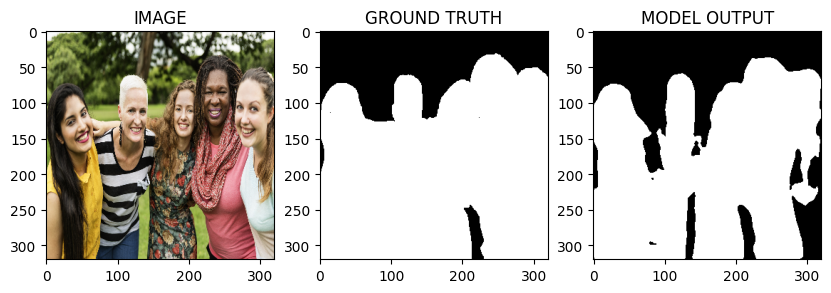

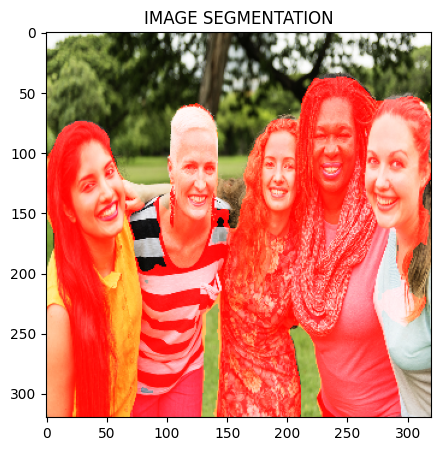

In [ ]:
# Making Inference

idx = 55

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # axis 0 to add the batch dimension (c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

show_image(image, mask, pred_mask.detach().cpu().squeeze(0))
overlay_image(image, pred_mask.detach().cpu().squeeze(0))

In [ ]:
# saving the model for future
from google.colab import drive
drive.mount('/content/drive')

!mkdir -p "/content/drive/MyDrive/ImageSegmentationProject"

!cp best_model.pt /content/drive/MyDrive/ImageSegmentationProject/

Mounted at /content/drive
